# Yolov3 theory and hands-on build
## Changes in Yolov3 in the comparison with Yolov2
Some changes has been made in order to improve the precission of this model. The transition from Yolov2 and Yolov3 is in the way of accuracy and performing by detecting the object and not in the way of reducing the time inference. It is not a big change but improves the performance, detecting some bugs of the previous model and some leakages which could be improved for better predictions.
This changes are the next:
- Detection at three scales. Some problems were detected in the small objects when detecting them. The application of three different scales detections has improved that performance. There are also some concatenations between those layers. Some concepts are important for understanding this type of implementations:

  * Passthrough Layer: This layer takes features from a previous layer with higher resolution and concatenates them with features from a subsequent layer with lower resolution.
  higher resolution and concatenates them with features from a later, lower resolution layer. Specifically, in YOLOv2, the output of a previous layer (with more spatial detail) is reorganised and concatenated with the output of a later layer, allowing the network to maintain and combine detailed and abstract information.
  * Concatenation in Multi-Scale Detection: YOLOv3 performs detections at three different resolutions, using three detection layers:

          1. Small objects -> 52x52 layer   
          2. Medium objects -> 26x26 layer
          3. Large objects -> 13x13 layer

- 9 numbers of anchor boxes at three layers result of the three scales and the three predictions of each class in the images.
- Softmax method for predicting classes is deprecated in this version, in order to eliminate the rigid predictions. Some predictions could be a mix of two in real-world scenarios, not a COCO dataset class prediction, which is restricted. Example of this is a person which is also a women. To avoid this: logistic regresion was used instead of this softmax method, which pushes forward only the most probable class.

In the COCO50 yolov3 is over RetinaNet with less time of inferencing, but this is not a real improvement. In the COCO75 benchmarking the Retinanet outperforms the yolov3 and demonstrate its better prediction quality. This could be seen in the next image:

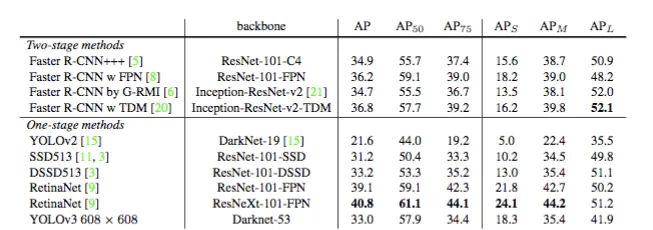

## Network architecture
The network architecture could be seen on the next image. This network will be treated to be applied programatically on the next stages of this analysis. The architecture of the network could be seen on the next Figure.

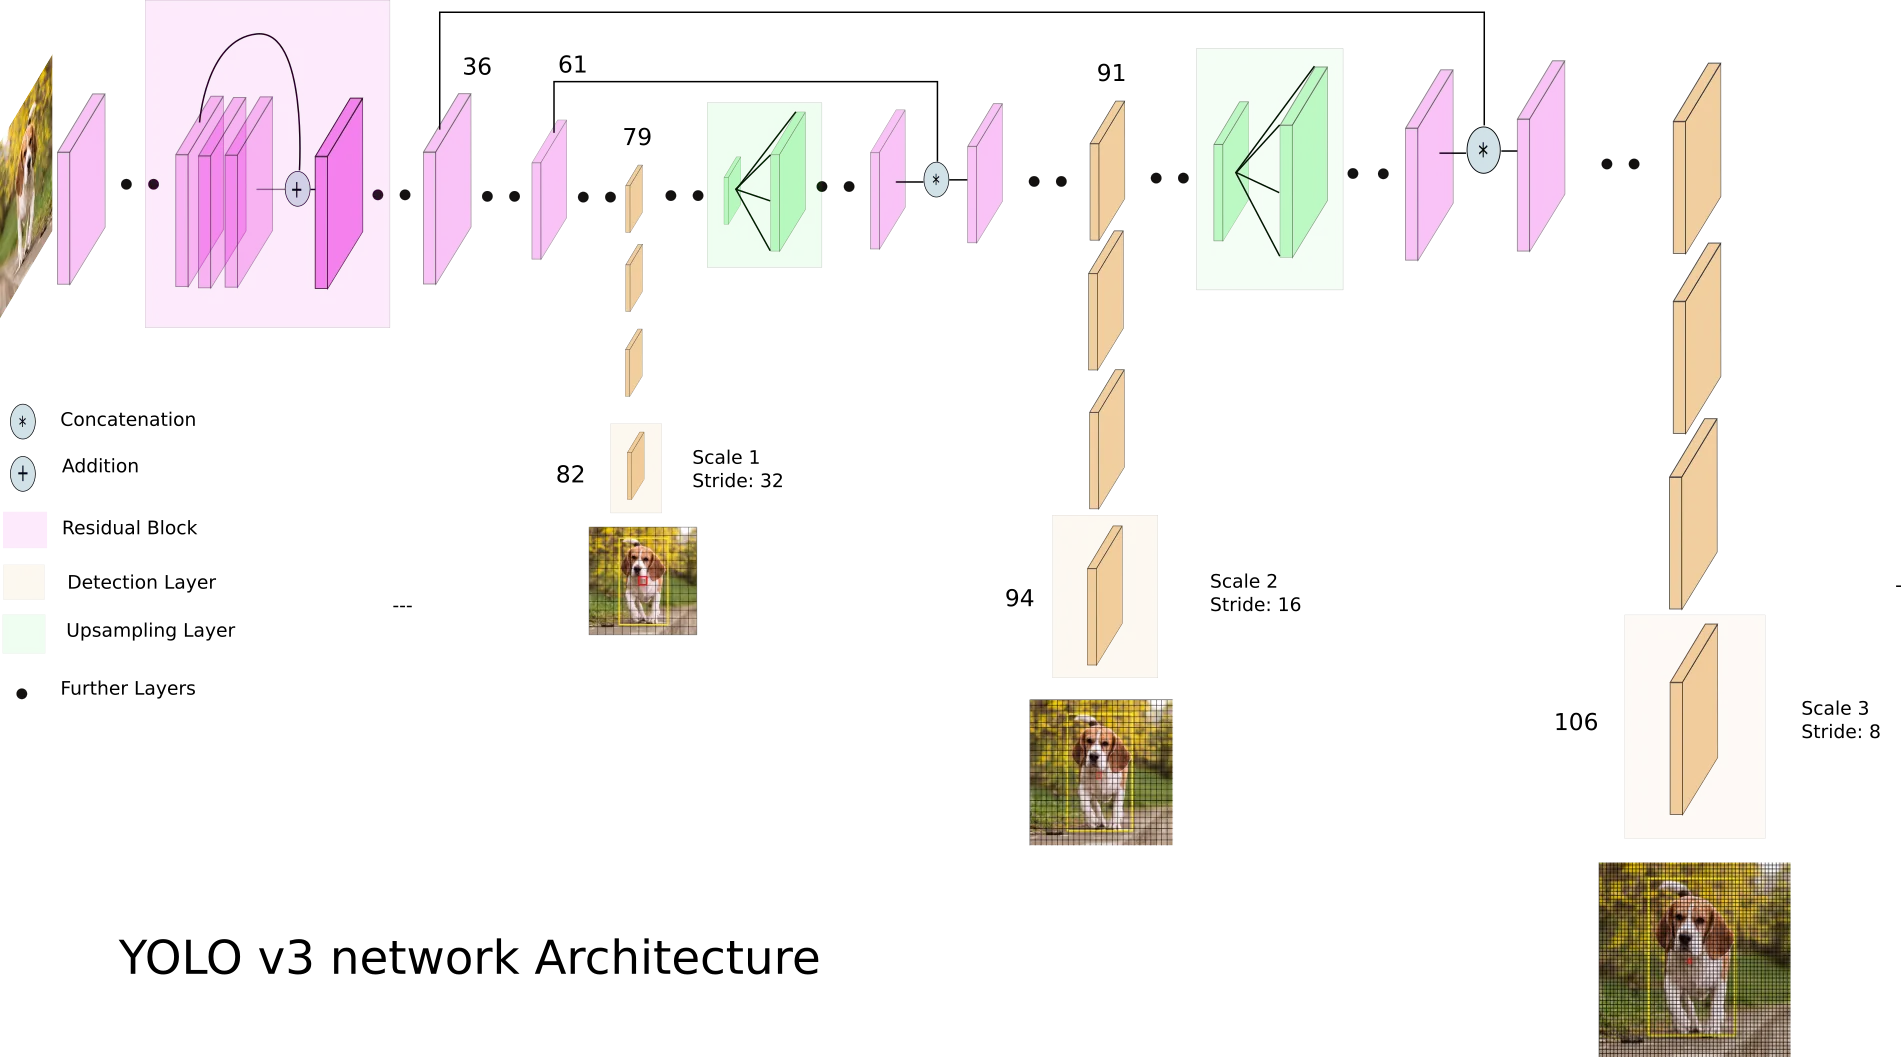

In the image we can see the structure of this yolov3 with the changes of the current convolutional network which we have talked about.

## Hands-on implementation of the Yolov3

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, Input, concatenate, add
from tensorflow.keras.models import Model

# Definición de DarknetConv2D
def DarknetConv2D(*args, **kwargs):
    darknet_conv_kwargs = {'kernel_regularizer': tf.keras.regularizers.l2(5e-4)}
    darknet_conv_kwargs.update(kwargs)
    return Conv2D(*args, **darknet_conv_kwargs)

# Definición de DarknetConv2D_BN_Leaky
def DarknetConv2D_BN_Leaky(*args, **kwargs):
    no_bias_kwargs = {'use_bias': False}
    no_bias_kwargs.update(kwargs)
    return tf.keras.Sequential([
        DarknetConv2D(*args, **no_bias_kwargs),
        BatchNormalization(),
        LeakyReLU(alpha=0.1)
    ])

# Definición de un bloque residual
def resblock_body(x, num_filters, num_blocks):
    x = ZeroPadding2D(((1, 0), (1, 0)))(x)
    x = DarknetConv2D_BN_Leaky(num_filters, (3, 3), strides=(2, 2))(x)
    for i in range(num_blocks):
        y = DarknetConv2D_BN_Leaky(num_filters // 2, (1, 1))(x)
        y = DarknetConv2D_BN_Leaky(num_filters, (3, 3))(y)
        x = add([x, y])
    return x

def darknet_body(inputs):
    x = DarknetConv2D_BN_Leaky(32, (3, 3))(inputs)
    x = resblock_body(x, 64, 1)
    x = resblock_body(x, 128, 2)
    x = resblock_body(x, 256, 8)
    x2 = x  # Salida intermedia después del bloque de 256 filtros
    x = resblock_body(x, 512, 8)
    x1 = x  # Salida intermedia después del bloque de 512 filtros
    x = resblock_body(x, 1024, 4)
    return x, x1, x2


# Definición de las capas finales de YOLO
def make_last_layers(x, num_filters, out_filters):
    x = DarknetConv2D_BN_Leaky(num_filters, (1, 1))(x)
    x = DarknetConv2D_BN_Leaky(num_filters * 2, (3, 3))(x)
    x = DarknetConv2D_BN_Leaky(num_filters, (1, 1))(x)
    x = DarknetConv2D_BN_Leaky(num_filters * 2, (3, 3))(x)
    x = DarknetConv2D_BN_Leaky(num_filters, (1, 1))(x)
    y = DarknetConv2D(out_filters, (1, 1))(x)
    return x, y

def yolo_body(inputs, num_anchors, num_classes):
    darknet, x1, x2 = darknet_body(inputs)
    x, y1 = make_last_layers(darknet, 512, num_anchors * (num_classes + 5))
    x = DarknetConv2D_BN_Leaky(256, (1, 1))(x)
    x = UpSampling2D(2)(x)
    x = concatenate([x, x1])
    x, y2 = make_last_layers(x, 256, num_anchors * (num_classes + 5))
    x = DarknetConv2D_BN_Leaky(128, (1, 1))(x)
    x = UpSampling2D(2)(x)
    x = concatenate([x, x2])
    x, y3 = make_last_layers(x, 128, num_anchors * (num_classes + 5))
    return Model(inputs, [y1, y2, y3])


# Construcción del modelo YOLOv3 completo
num_classes = 80  # número de clases (por ejemplo, COCO dataset)
num_anchors = 3   # número de anchors

inputs = Input(shape=(None, None, 3))
model = yolo_body(inputs, num_anchors, num_classes)
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 sequential_110 (Sequential  (None, None, None, 32)       992       ['input_4[0][0]']             
 )                                                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPad  (None, None, None, 32)       0         ['sequential_110[0][0]']      
 ding2D)                                                                                          
                                                                                            